# Power analysis using Monte Carlo simulations in R

Edoardo "Dado" Marcora  
2024-03-19

## Introduction

Several R functions and packages (e.g., the built-in `stats::power.*`
functions or the
[`pwr`](https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html)
and
[`pwrss`](https://cran.r-project.org/web/packages/pwrss/vignettes/examples.html)
packages) as well as desktop (e.g.,
[G\*Power](https://www.psychologie.hhu.de/arbeitsgruppen/allgemeine-psychologie-und-arbeitspsychologie/gpower.html),)
or web (e.g., [powerandsamplesize.com](https://powerandsamplesize.com/),
[pwrss](https://pwrss.shinyapps.io/index/), [sample size
justification](https://shiny.ieis.tue.nl/sample_size_justification/))
applications are used to perform power analysis of classical
null-hypothesis significance tests for simple statistical models and
study designs. However, this notebook focuses on the more general
approach of using [Monte Carlo
simulations](https://ritsokiguess.site/blogg/posts/2021-11-14-tidy-simulation/)
(Morris, White, and Crowther 2019) and (specifically and more
conveniently) the [`mlpwr`](https://github.com/flxzimmer/mlpwr) package
to perform power analysis of significance tests for statistical models
and study designs of any complexity (Zimmer, Henninger, and Debelak
2023).

## Setup environment

In [ ]:
library(tidyverse)
library(coursekata)
library(performance)
library(parameters)
library(effectsize)
library(ggeffects)

set.seed(123)

options(scipen = 0, ggeffects_margin = "empirical")

## Background information

*A-priori* power analysis is critical for study design, sample size
justification, and the interpretation of scientific claims based on
null-hypothesis significance testing (NHST) 😭 (Lakens 2022). In
particular, it allows us to estimate the minimum sample size required to
detect an “effect” of a given size with a given level of confidence,
given the probability of detecting such an “effect” (power). Conversely,
under sample size constraints, it allows us to estimate the probability
of detecting an “effect” of a given size with a given level of
confidence (power), given a sample size.

If the inferential goal of a study is NHST 😭 and statistical power is
low, then we should modify the design of the study in order to increase
power (e.g., by increasing the sample size) or we may consider
abandoning it to avoid wasting time and money.

If the inferential goal of a study is NHST 😭, there are four possible
outcomes:

1.  A **false positive** (FP or Type I error), determined by ⍺ (the Type
    I error rate). The test yields a significant result, even though the
    null-hypothesis is true.

2.  A **false negative** (FN or Type II error), determined by β (the
    Type II error rate). The test yields a non-significant result, even
    though the alternative hypothesis is true.

3.  A **true negative** (TN), determined by 1 - ⍺. The test yields a
    non-significant result when the null-hypothesis is true.

4.  A **true positive** (TP), determined by 1 - β = **power**. The test
    yields a significant result when the alternative hypothesis is true.

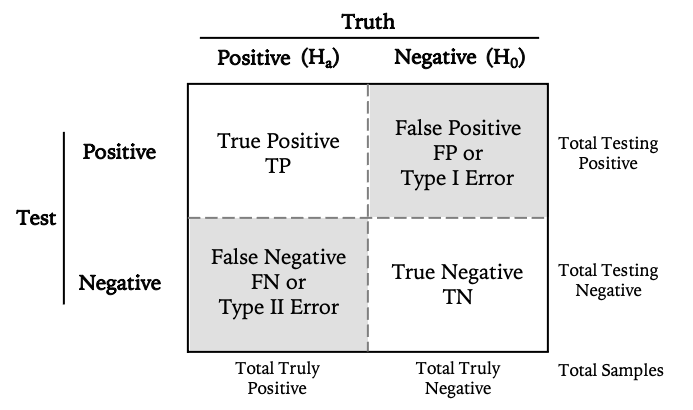

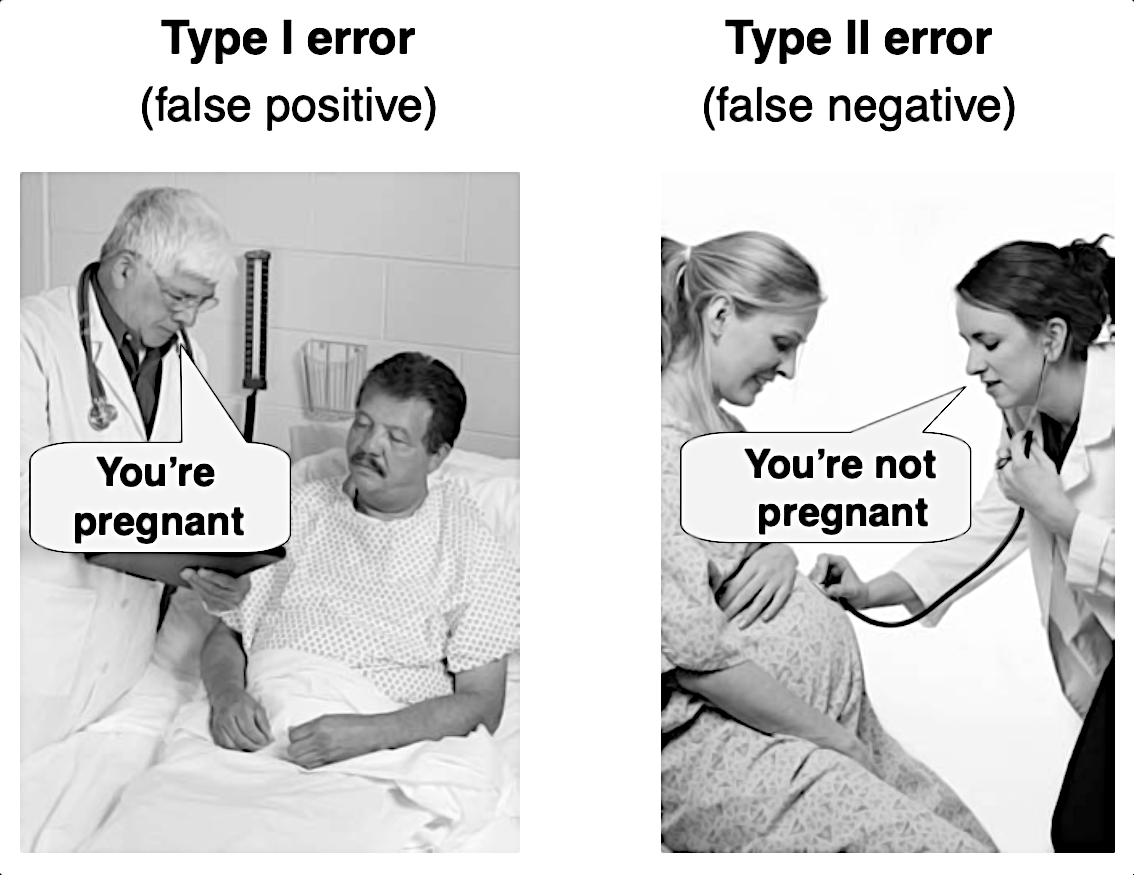

The median statistical power of studies in neuroscience is estimated to
be 21% \[8-31%\] (Button et al. 2013). This is rather unfortunate,
because low power increases the likelihood that 1) a statistically
significant results is a false positive (\>50% of published research
findings are likely to be false positives (Ioannidis 2005)), and that 2)
the effect size of a true positive results is overestimated (a.k.a. the
“*winner’s curse*”).

------------------------------------------------------------------------

The following **four quantities** have an intimate relationship in power
analysis:

1.  **significance level**, ⍺ = P(Type 1 error), i.e., the probability
    of concluding that there *is* an effect when there is *no* effect.

2.  **power level**, 1 - β, β = P(Type 2 error), i.e., the probability
    of concluding there is *no* effect when there *is* an effect.

3.  **effect size**

4.  **sample size**

Given any three, we can determine the fourth.

### Significance level

A generally accepted significance level/type I error rate α is 0.05.
However, the default use of an significance level of 5% is sub-optimal
(Maier and Lakens 2022).

### Power level

A generally accepted minimum level of power (1 - Type II error rate β)
is 0.80 (Cohen 1988). This minimum is based on the idea that with a Type
I error rate of 0.05, the ratio of a Type II error to a Type I error is
0.20/0.05 = 4. In this setup, concluding that there *is* an effect when
there is *no* effect (Type I error) is considered four times more costly
than concluding there is *no* effect when there *is* an effect (Type II
error). However, the default use of a power level of 80% is sub-optimal
(Lakens 2022).

### Effect size

In statistics, an [effect
size](https://en.wikipedia.org/wiki/Effect_size) is a value measuring
the strength of a statistical association between two variables in a
“population”, or a sample-based estimate of that quantity. Despite the
misleading use of causal language, the term “effect” in statistics does
NOT imply a causal relationship between the two variables (association ≠
causation).

The effect sizes used in power analysis should be informed by expert
knowledge, a theoretical model, an exploratory study performed before
calculating the minimum sample size required for a confirmatory study,
or by searching the literature for effect sizes estimated in similar
studies or (better) meta-analyses thereof. As a very last resort, Common
Language Effect Size (CLES) indicators (McGraw and Wong 1992) or
benchmarks provided by (Cohen 1988), (Chen, Cohen, and Chen 2010), and
(Funder and Ozer 2019) can be used, but these can vary greatly depending
on the field of study.

<table style="width:97%;">
<colgroup>
<col style="width: 21%" />
<col style="width: 29%" />
<col style="width: 15%" />
<col style="width: 15%" />
<col style="width: 15%" />
</colgroup>
<thead>
<tr>
<th>Test</th>
<th>Effect size measure</th>
<th>Small<br />
(% variance)</th>
<th>Medium<br />
(% variance)</th>
<th>Large<br />
(% variance)</th>
</tr>
</thead>
<tbody>
<tr>
<td><em>t</em>-test</td>
<td>Cohen’s <em>d</em><br />
(or Hedges’s <em>g</em> if N ≤ 20)</td>
<td>0.20<br />
(1%)</td>
<td>0.50<br />
(6%)</td>
<td>0.80<br />
(16%)</td>
</tr>
<tr>
<td>Correlation/<br />
Simple regression</td>
<td>Pearson’s <em>r</em></td>
<td>0.10 [0.1]<br />
(1%)</td>
<td>0.25 [0.3]<br />
(6%)</td>
<td>0.40 [0.5]<br />
(16%)</td>
</tr>
<tr>
<td>Multiple regression</td>
<td>R<sup>2</sup></td>
<td>0.02<br />
(2%)</td>
<td>0.13<br />
(13%)</td>
<td>0.26<br />
(26%)</td>
</tr>
<tr>
<td>Multiple regression</td>
<td><em>f</em><sup>2</sup></td>
<td>0.02<br />
(2%)</td>
<td>0.15<br />
(13%)</td>
<td>0.35<br />
(26%)</td>
</tr>
<tr>
<td>Logistic regression</td>
<td>OR<sup>*</sup></td>
<td>1.46</td>
<td>2.50</td>
<td>4.14</td>
</tr>
</tbody>
</table>

<sup>\*</sup> assuming a 10% probability of the outcome in the control
group (Chen, Cohen, and Chen 2010)

$\text{Cohen's}\ d = \frac{M_1 - M_2}{SD_{\text{pooled}}} = \frac{M_1 - M_2}{\sqrt{(SD_1^2 + SD_2^2)/2}}$

Omnibus *F* test for one model: $f^2 = \frac{R^2}{1-R^2}$

Omnibus *F* test for two (nested) models:
$f^2 = \frac{R^2_{AB} - R^2_A}{1-R^2_{AB}}$

### See also

-   [Improving your statistical inferences: Effect
    size](https://lakens.github.io/statistical_inferences/06-effectsize.html)

-   [Improving your statistical inferences: Sample size
    justification](https://lakens.github.io/statistical_inferences/08-samplesizejustification.html)

-   [Quick-R: Power
    analysis](https://www.statmethods.net/stats/power.html)

<https://youtu.be/VX_M3tIyiYk?si=_GD96QuJPt2AO_Zt>

## Read and prep data from pilot study

In the power analysis examples that follow, we will use real data from a
pilot study (or synthetic data from a simulated study) of the effect
that knocking out a gene (`geno`) has on a phenotype (`pheno`).

In [ ]:
d1 <- read_csv("pilot.csv", show_col_types = FALSE)

d1

# A tibble: 12 × 2
   pheno geno 
   <dbl> <chr>
 1  51.8 WT   
 2  55.5 WT   
 3  75.1 WT   
 4  58.8 WT   
 5  59.4 WT   
 6  76.9 WT   
 7  82.5 KO   
 8  61.8 KO   
 9  68.8 KO   
10  71.7 KO   
# ℹ 2 more rows

## Exploratory data analysis

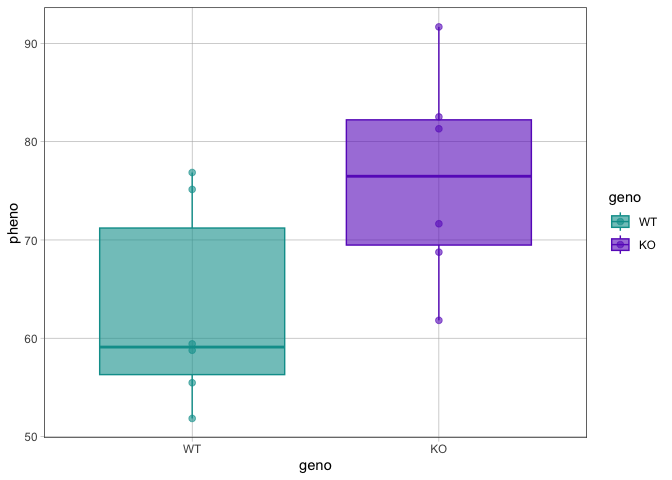

In [ ]:
gf_boxplot(pheno ~ geno, color = ~ geno, fill = ~ geno, data = d1) %>%
  gf_point()

In [ ]:
favstats(pheno ~ geno, data = d1)

  geno   min    Q1 median    Q3   max  mean    sd n missing
1   WT 51.83 56.29  59.10 71.21 76.87 62.92 10.51 6       0
2   KO 61.82 69.48  76.48 82.23 91.69 76.29 10.85 6       0

## Fit simple linear regression model to the data

In [ ]:
m1 <- lm(pheno ~ geno, data = d1)

summary(m1)


Call:
lm(formula = pheno ~ geno, data = d1)

Residuals:
   Min     1Q Median     3Q    Max 
-14.47  -7.47  -3.82   7.73  15.39 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    62.92       4.36   14.43  5.1e-08 ***
genoKO         13.38       6.17    2.17    0.055 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 10.7 on 10 degrees of freedom
Multiple R-squared:  0.32,  Adjusted R-squared:  0.252 
F-statistic:  4.7 on 1 and 10 DF,  p-value: 0.0553

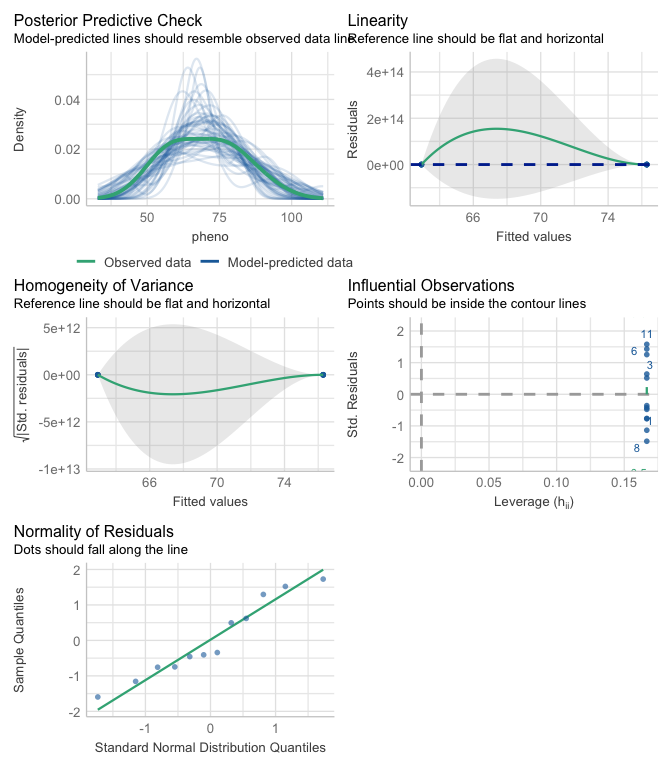

In [ ]:
check_model(m1, detrend = FALSE)

## Evaluate model and compute effect sizes

In [ ]:
model_parameters(m1)

Parameter   | Coefficient |   SE |         95% CI | t(10) |      p
------------------------------------------------------------------
(Intercept) |       62.92 | 4.36 | [53.20, 72.63] | 14.43 | < .001
geno [KO]   |       13.38 | 6.17 | [-0.36, 27.12] |  2.17 | 0.055 

In [ ]:
supernova(m1)

 Analysis of Variance Table (Type III SS)
 Model: pheno ~ geno

                               SS df      MS     F   PRE     p
 ----- --------------- | -------- -- ------- ----- ----- -----
 Model (error reduced) |  536.735  1 536.735 4.705 .3200 .0553
 Error (from model)    | 1140.782 10 114.078                  
 ----- --------------- | -------- -- ------- ----- ----- -----
 Total (empty model)   | 1677.517 11 152.502                  

R-squared ($R^2$ a.k.a. [coefficient of
determination](https://en.wikipedia.org/wiki/Coefficient_of_determination))
is the same as the *proportional reduction in error* (PRE) for the
overall model \[`Model (error reduced) PRE`\] in the output of the
`supernova()` function. R-squared is the proportion of variance in the
dependent variable that can be explained by the independent variable(s)
in a regression model. In other words, R-squared shows how well the
model fits the data (the goodness of fit) and is a standardized measure
of effect size for a regression model.

In [ ]:
r2 <- rsquared(m1)

r2

[1] 0.32

The linear regression model with one categorical predictor that we
fitted above is equivalent to a two sample *t*-test:

In [ ]:
t.test(pheno ~ geno, data = d1, var.equal = TRUE)


    Two Sample t-test

data:  pheno by geno
t = -2.2, df = 10, p-value = 0.06
alternative hypothesis: true difference in means between group WT and group KO is not equal to 0
95 percent confidence interval:
 -27.1157   0.3641
sample estimates:
mean in group WT mean in group KO 
           62.92            76.29 

Cohen’s *d* is a standardized measure of effect size for a *t*-test:

In [ ]:
cohens_d(pheno ~ geno, data = d1) %>% interpret_cohens_d()

Cohen's d |        95% CI | Interpretation
------------------------------------------
-1.25     | [-2.48, 0.03] |          large

- Estimated using pooled SD.
- Interpretation rule: cohen1988

Finally, we compute the adjusted predictions and marginal effects of the
model we fitted above using the
[`ggeffects`](https://strengejacke.github.io/ggeffects/) package as
[previously shown](../marginal_effects):

In [ ]:
pred1 <- predict_response(m1, "geno")

pred1

# Average predicted values of pheno

geno | Predicted |       95% CI
-------------------------------
WT   |     62.92 | 53.20, 72.63
KO   |     76.29 | 66.58, 86.01

In [ ]:
test_predictions(pred1)

Marginal Contrasts Analysis

Level1 | Level2 | Difference |   SE |         95% CI | t(10) |     p
--------------------------------------------------------------------
KO     | WT     |      13.38 | 6.17 | [-0.36, 27.12] |  2.17 | 0.055

Variable predicted: pheno
Predictors contrasted: geno

<u>Do NOT describe “almost statistically significant” results like this
one as “trending towards statistical significance”</u>! There is no such
a thing as a “trend towards statistical significance” in probability
theory/statistical inference. It is just
[mambo-jumbo](https://mchankins.wordpress.com/2013/04/21/still-not-significant-2/)
used by followers of the “*null ritual*” to describe the result of a
significance test when the *p*-value is near but not below the magical
(yet completely arbitrary) threshold of 0.05 (Gigerenzer, Krauss, and
Vitouch 2004). Implying that a nearly significant *p*-value indicates
such a trend or suggesting that the failure to achieve statistical
significance was due to an insufficient amount of data is not only
wholly mistaken but also actively misleading. This is because a
*p*-value is quite likely to become less significant if data are added
(Wood et al. 2014).

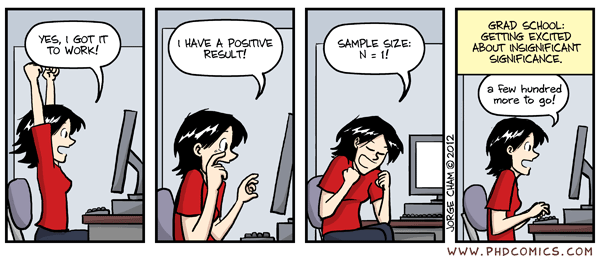

## Power analysis using pre-made functions

Although not useful at all (because, *a-posteriori*, power is simply a
statistical restatement of the *p*-value), we can calculate the power of
our pilot study:

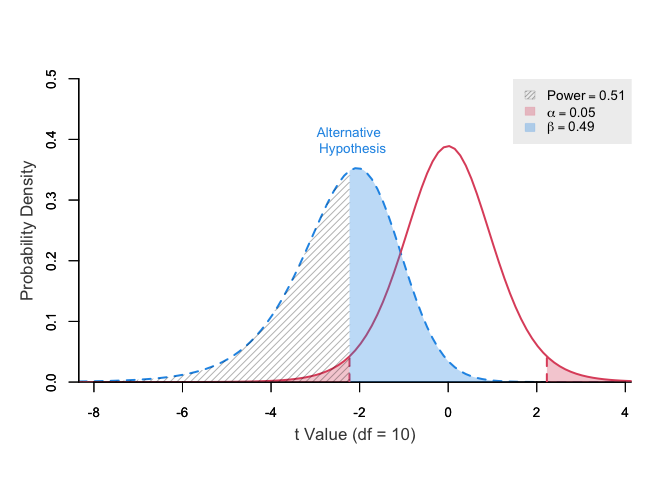

 power ncp.alt ncp.null alpha df t.crit.1 t.crit.2
 0.511    -2.2        0  0.05 10   -2.228    2.228

In [ ]:
pwrss::power.t.test(ncp = -2.2, df = 10)

Assuming that the simple linear regression model we fitted to the pilot
study data is a decent approximation of the DGP<sup>\*</sup>, we can
calculate the minimum sample size required to achieve a power level of
0.80 to detect the effect size we estimated above at an alpha level of
0.05, using the built-in `stats::power.t.test` function or analogous
functions in the
[`pwr`](https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html)
and
[`pwrss`](https://cran.r-project.org/web/packages/pwrss/vignettes/examples.html)
packages:

In [ ]:
stats::power.t.test(delta = -13.38, sd = 10.7,
                    power = 0.80, sig.level = 0.05)


     Two-sample t test power calculation 

              n = 11.09
          delta = 13.38
             sd = 10.7
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group

In [ ]:
pwrss::pwrss.t.2means(mu1 = 62.92, sd1 = 10.51,
                      mu2 = 76.29, sd2 = 10.85,
                      power = 0.80, alpha = 0.05)

 Difference between Two means 
 (Independent Samples t Test) 
 H0: mu1 = mu2 
 HA: mu1 != mu2 
 ------------------------------ 
  Statistical power = 0.8 
  n1 = 12 
  n2 = 12 
 ------------------------------ 
 Alternative = "not equal" 
 Degrees of freedom = 22 
 Non-centrality parameter = -3.066 
 Type I error rate = 0.05 
 Type II error rate = 0.2 

In [ ]:
pwr::pwr.t.test(d = 1.25,
                power = 0.80, sig.level = 0.05)


     Two-sample t test power calculation 

              n = 11.09
              d = 1.25
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group

<sup>\*</sup> this assumption is not well justified, because the sample
size of the pilot study is rather small and thus the effect size
estimate is very uncertain `d = 1.25 [0.03, 2.48]`. When searching the
literature for effect sizes estimated in similar studies, be aware that
(because of low power and publication bias) these effect sizes are
likely to be overestimated (2X, see the figure below from “Estimating
the Reproducibility of Psychological Science” (2015), but see also
counterpoint by Patil, Peng, and Leek (2016)). Therefore, the most
reliable estimates of effect sizes are not from single studies but from
meta-analyses that takes publication bias into account (Lakens 2022).

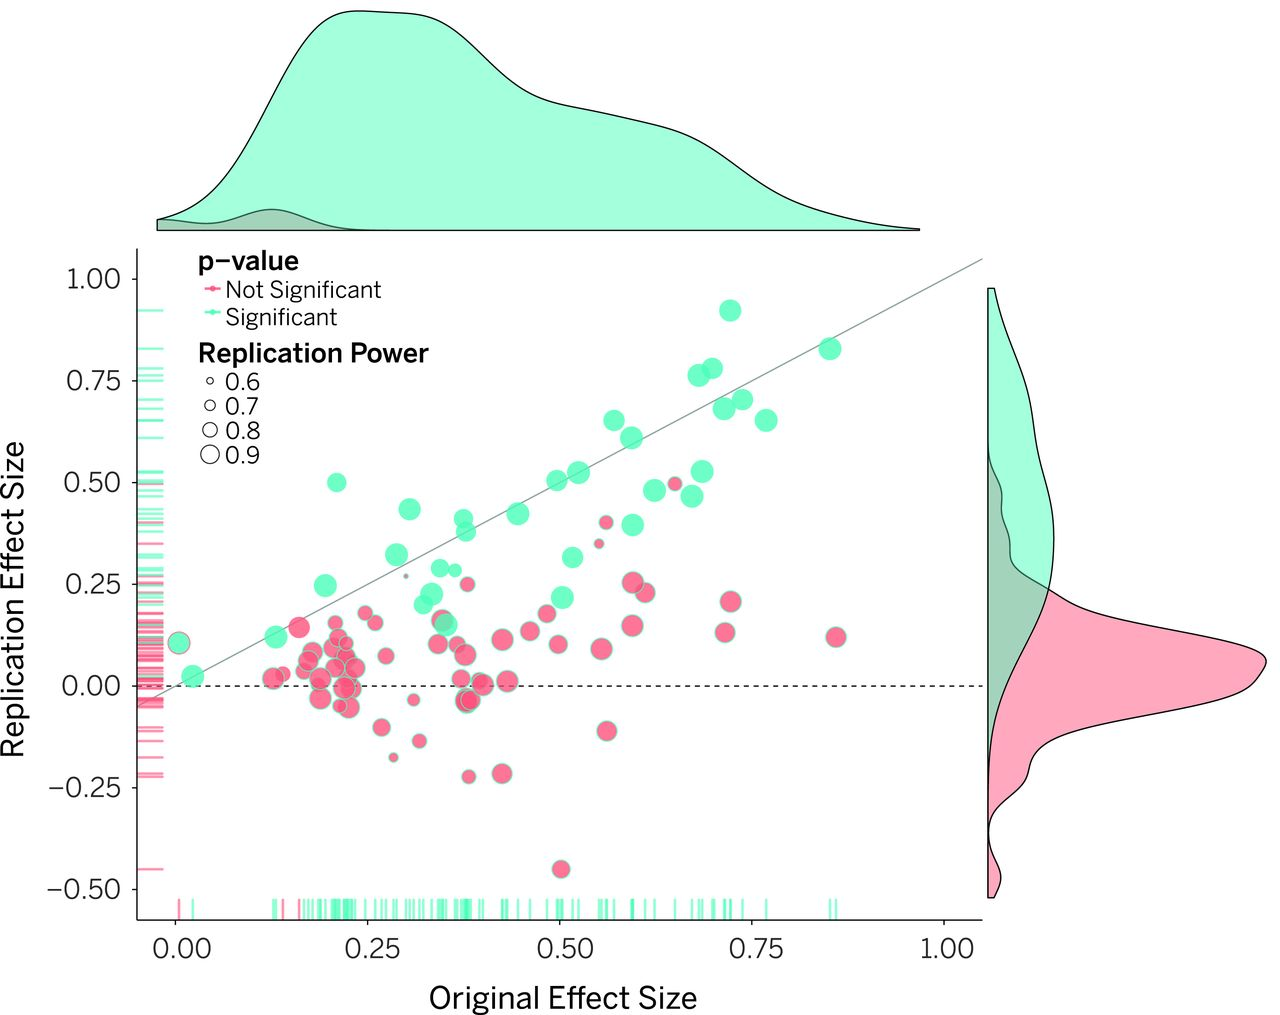

Power analysis at the boundaries of the effect size 95% CI and at half
size:

In [ ]:
pwr::pwr.t.test(d = 0.03,
                power = 0.80, sig.level = 0.05)


     Two-sample t test power calculation 

              n = 17443
              d = 0.03
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


     Two-sample t test power calculation 

              n = 3.799
              d = 2.48
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


     Two-sample t test power calculation 

              n = 41.17
              d = 0.625
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group

Click [here](pwrss_linreg.html) for examples on how to use the
[`pwrss`](https://cran.r-project.org/web/packages/pwrss/vignettes/examples.html)
package to perform power analysis for multiple regression models and
different types of significance tests (NHST, non-inferiority/superiority
tests, and equivalence tests).

## Power analysis using Monte Carlo simulations

For more complex statistical models and study designs, estimates of
power can only be obtained using Monte Carlo simulations. For this more
computationally expensive but also much more flexible approach, we need
to define a function that, <u>given a sample size (N)</u>:

1.  simulates data (from a model of the DGP or by resampling)

2.  performs significance testing

3.  returns the *p* value of the significance test

In [ ]:
sim_p.gen <- function(n) {
  # simulate data by generating synthetic data
  mean.WT <- 62.92; sd.WT <- 10.51
  mean.KO <- 76.29; sd.KO <- 10.85
  
  pheno.WT <- rnorm(n, mean = mean.WT, sd = sd.WT)
  pheno.KO <- rnorm(n, mean = mean.KO, sd = sd.KO)
  
  d.WT <- tibble(pheno = pheno.WT, geno = "WT")
  d.KO <- tibble(pheno = pheno.KO, geno = "KO")
  
  d <- bind_rows(d.WT, d.KO)
  
  # perform significance testing
  m <- lm(pheno ~ geno, data = d)
  
  # return p-value of significance test
  p(m)
}

In [ ]:
sim_p.res <- function(n) {
  # simulate data by resampling real data
  d <- d1 %>% group_by(geno) %>% sample_n(n, replace = TRUE)
  
  # perform significance testing
  m <- lm(pheno ~ geno, data = d)
  
  # return p-value of significance test
  p(m)
}

In [ ]:
sim_p.res.null <- function(n) {
  # simulate data by resampling real data
  d <- d1 %>% group_by(geno) %>% sample_n(n, replace = TRUE)
  
  # perform significance testing (remove effect by shuffling)
  m <- lm(shuffle(pheno) ~ geno, data = d)
  
  # return p-value of significance test
  p(m)
}

### Run Monte Carlo simulation a large number of times and visualize the *p* value distribution for a specific sample size

In [ ]:
M <- 1000 # number of Monte Carlo simulations
N <- 6    # sample size

In [ ]:
sim_ps <- do(M) * sim_p.gen(N)

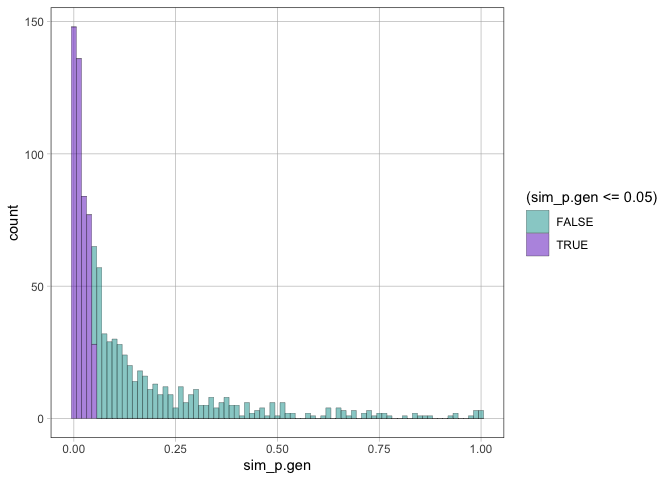

In [ ]:
gf_histogram(~ sim_p.gen, fill = ~ (sim_p.gen <= 0.05), binwidth = 0.0125, data = sim_ps)

The proportion of *p*-values below the significance level (e.g.,
$\alpha = 0.05$) when the alternative hypothesis is true is equal to 1 -
β, i.e., the power level:

In [ ]:
tally(sim_ps <= 0.05, format = "proportion")

X
 TRUE FALSE 
0.473 0.527 

In [ ]:
sim_ps <- do(M) * sim_p.res(N)

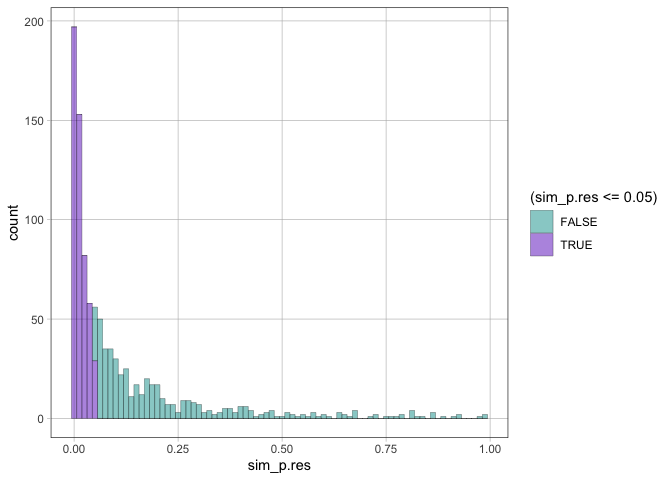

In [ ]:
gf_histogram(~ sim_p.res, fill = ~ (sim_p.res <= 0.05), binwidth = 0.0125, data = sim_ps)

In [ ]:
tally(sim_ps <= 0.05, format = "proportion")

X
 TRUE FALSE 
0.519 0.481 

The proportion of *p*-values below the significance level (e.g.,
$\alpha = 0.05$) assuming the null hypothesis is true is equal to ⍺,
i.e., the significance level:

In [ ]:
sim_ps <- do(M) * sim_p.res.null(N)

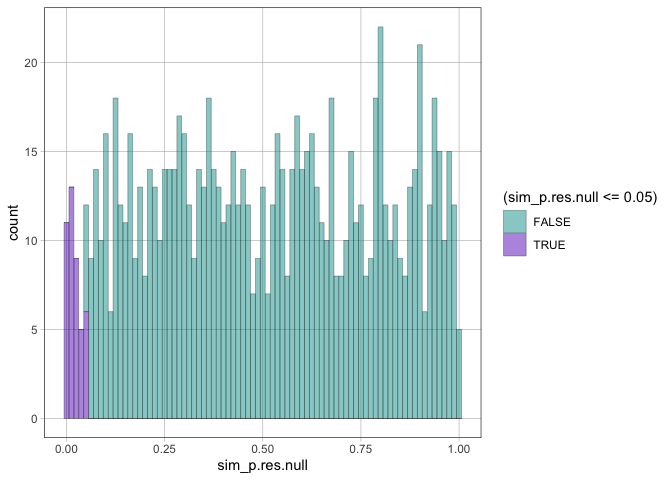

In [ ]:
gf_histogram(~ sim_p.res.null, fill = ~ (sim_p.res.null <= 0.05), binwidth = 0.0125, data = sim_ps)

In [ ]:
tally(sim_ps <= 0.05, format = "proportion")

X
 TRUE FALSE 
0.044 0.956 

### Find design by running the Monte Carlo simulation a large number of times and visualize the power curve for a range of sample sizes

The `find.design()` function of the
[`mlpwr`](https://github.com/flxzimmer/mlpwr) package (Zimmer,
Henninger, and Debelak 2023) takes as first argument a simulation
function (similar to the ones above) that takes the sample size as input
and returns `TRUE` or `FALSE` if the computed *p*-value is below the
specified significance level (here we reuse the `sim_p.gen()` function
above by wrapping it in an [anonymous
function](https://towardsdatascience.com/the-new-pipe-and-anonymous-function-syntax-in-r-54d98861014c)
that check whether the returned *p*-value is below the specified
significance level):

In [ ]:
ds <- mlpwr::find.design(\(n) sim_p.gen(n) <= 0.05, # alpha level
                         boundaries = c(4, 40),     # range of sample sizes
                         power = 0.80,              # power level (1 - beta)
                         evaluations = M)           # number of Monte Carlo simulations

Print the power analysis results:

In [ ]:
summary(ds)


Call:
mlpwr::find.design(simfun = function(n) sim_p.gen(n) <= 0.05, 
    boundaries = c(4, 40), power = 0.8, evaluations = M)

Design: n = 12

Power: 0.83865,  SE: 0.01268
Evaluations: 1000,  Time: 4.09,  Updates: 16
Surrogate: Logistic regression

Plot the power analysis results:

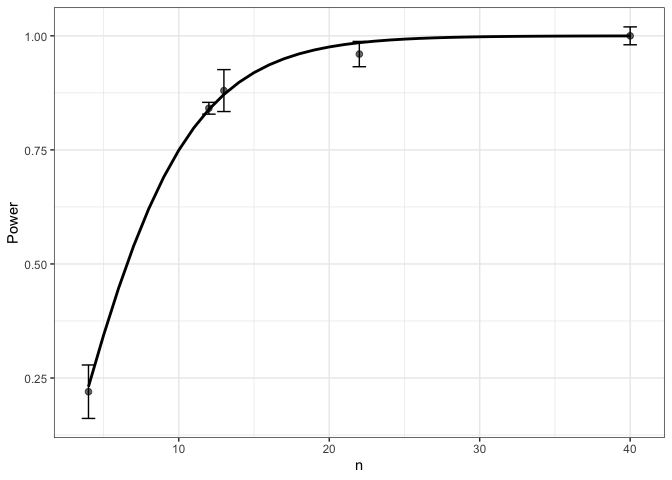

In [ ]:
plot(ds, addribbon = FALSE, adderrorbars = TRUE)

## References

Button, Katherine S., John P. A. Ioannidis, Claire Mokrysz, Brian A.
Nosek, Jonathan Flint, Emma S. J. Robinson, and Marcus R. Munafò. 2013.
“Power Failure: Why Small Sample Size Undermines the Reliability of
Neuroscience.” *Nature Reviews Neuroscience* 14 (5): 365–76.
<https://doi.org/10.1038/nrn3475>.

Chen, Henian, Patricia Cohen, and Sophie Chen. 2010. “How Big Is a Big
Odds Ratio? Interpreting the Magnitudes of Odds Ratios in
Epidemiological Studies.” *Communications in Statistics - Simulation and
Computation* 39 (4): 860–64.
<https://doi.org/10.1080/03610911003650383>.

Cohen, Jacob. 1988. *Statistical Power Analysis for the Behavioral
Sciences*. Routledge. <https://doi.org/10.4324/9780203771587>.

“Estimating the Reproducibility of Psychological Science.” 2015.
*Science* 349 (6251). <https://doi.org/10.1126/science.aac4716>.

Funder, David C., and Daniel J. Ozer. 2019. “Evaluating Effect Size in
Psychological Research: Sense and Nonsense.” *Advances in Methods and
Practices in Psychological Science* 2 (2): 156–68.
<https://doi.org/10.1177/2515245919847202>.

Gigerenzer, Gerd, Stefan Krauss, and Oliver Vitouch. 2004. “The Null
Ritual: What You Always Wanted to Know about Significance Testing but
Were Afraid to Ask.” In, 392–409. SAGE Publications, Inc.
<https://doi.org/10.4135/9781412986311.n21>.

Ioannidis, John P. A. 2005. “Why Most Published Research Findings Are
False.” *PLoS Medicine* 2 (8): e124.
<https://doi.org/10.1371/journal.pmed.0020124>.

Lakens, Daniël. 2022. “Sample Size Justification.” *Collabra:
Psychology* 8 (1). <https://doi.org/10.1525/collabra.33267>.

Maier, Maximilian, and Daniël Lakens. 2022. “Justify Your Alpha: A
Primer on Two Practical Approaches.” *Advances in Methods and Practices
in Psychological Science* 5 (2): 251524592210803.
<https://doi.org/10.1177/25152459221080396>.

McGraw, Kenneth O., and S. P. Wong. 1992. “A Common Language Effect Size
Statistic.” *Psychological Bulletin* 111 (2): 361–65.
<https://doi.org/10.1037/0033-2909.111.2.361>.

Morris, Tim P., Ian R. White, and Michael J. Crowther. 2019. “Using
Simulation Studies to Evaluate Statistical Methods.” *Statistics in
Medicine* 38 (11): 2074–2102. <https://doi.org/10.1002/sim.8086>.

Patil, Prasad, Roger D. Peng, and Jeffrey T. Leek. 2016. “What Should
Researchers Expect When They Replicate Studies? A Statistical View of
Replicability in Psychological Science.” *Perspectives on Psychological
Science* 11 (4): 539–44. <https://doi.org/10.1177/1745691616646366>.

Wood, J., N. Freemantle, M. King, and I. Nazareth. 2014. “Trap of Trends
to Statistical Significance: Likelihood of Near Significant P Value
Becoming More Significant with Extra Data.” *BMJ* 348 (mar31 2):
g2215–15. <https://doi.org/10.1136/bmj.g2215>.

Zimmer, Felix, Mirka Henninger, and Rudolf Debelak. 2023. “Sample Size
Planning for Complex Study Designs: A Tutorial for the Mlpwr Package.”
*Behavior Research Methods*, November.
<https://doi.org/10.3758/s13428-023-02269-0>.

## Print environment

In [ ]:
sessioninfo::session_info()

─ Session info ───────────────────────────────────────────────────────────────
 setting  value
 version  R version 4.4.2 (2024-10-31)
 os       macOS Sequoia 15.3.1
 system   aarch64, darwin20
 ui       X11
 language (EN)
 collate  en_US.UTF-8
 ctype    en_US.UTF-8
 tz       America/New_York
 date     2025-02-26
 pandoc   3.2 @ /Applications/RStudio.app/Contents/Resources/app/quarto/bin/tools/aarch64/ (via rmarkdown)
 quarto   1.6.42 @ /usr/local/bin/quarto

─ Packages ───────────────────────────────────────────────────────────────────
 package             * version  date (UTC) lib source
 backports             1.5.0    2024-05-23 [1] CRAN (R 4.4.0)
 bayestestR            0.15.2   2025-02-07 [1] CRAN (R 4.4.1)
 bit                   4.5.0.1  2024-12-03 [1] CRAN (R 4.4.1)
 bit64                 4.6.0-1  2025-01-16 [1] CRAN (R 4.4.1)
 checkmate             2.3.2    2024-07-29 [1] CRAN (R 4.4.0)
 cli                   3.6.4    2025-02-13 [1] CRAN (R 4.4.1)
 coda                  0.19-4.1 